# ROSSMAN SALES PREDICTION

# 1. Problem Description

# 2. Imports and Helper Functions

In [268]:
import math
import numpy  as np
import pandas as pd
import random
import warnings
import inflection
import seaborn as sns
import xgboost as xgb
import datetime

from matplotlib            import pyplot as plt
from IPython.core.display  import HTML


from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, FunctionTransformer, OneHotEncoder
from sklearn.pipeline      import Pipeline, make_pipeline
from sklearn.compose       import ColumnTransformer, TransformedTargetRegressor
from sklearn.linear_model    import LinearRegression

warnings.filterwarnings('ignore')

In [224]:
def mean_absolute_percentage_error(y, y_pred):
    return np.mean(np.abs((y - y_pred)/y))

    
def ml_error(model_name, y, y_pred):
    mae = mean_absolute_error(y, y_pred)
    mape = mean_absolute_percentage_error(y, y_pred)
    rmse = np.sqrt( mean_squared_error(y, y_pred))
    return pd.DataFrame( { 'Model Name': model_name, 
                           'MAE': mae, 
                           'MAPE': mape,
                           'RMSE': rmse }, index=[0] )

def cross_validation(df, kfold, model_name, model, verbose=False):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed(range(1, kfold +1)):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
        # start and end date for validation 
        validation_start_date = df['Date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = df['Date'].max() - datetime.timedelta(days=(k-1)*6*7)

        # filtering dataset
        train = df[df['Date'] < validation_start_date]
        test = df[(df['Date'] >= validation_start_date) & (df['Date'] <= validation_end_date)]

        # train
        X_train = train.drop(['Customers', 'Sales'], axis=1)
        y_train = train['Sales']

        # validation
        X_test = test.drop(['Customers', 'Sales'], axis=1)
        y_test = test['Sales']

        # model
        m = model.fit(X_train, y_train)

        # prediction
        y_pred = m.predict(X_test)

        # performance
        m_result = ml_error(model_name, y_test, y_pred)

        # store performance of each kfold iteration
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                          'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ) }, index=[0] )


def jupyter_settings():
    %matplotlib inline
    
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display(HTML('<style>.container { width:100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)

    sns.set_theme()

In [225]:
jupyter_settings()

# 3. Data Preparation

## 3.1 Data Import

In [4]:
df_sales_raw = pd.read_csv('/Users/lucasstelmastchuk/Documents/repos/rossman_sales/data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('/Users/lucasstelmastchuk/Documents/repos/rossman_sales/data/store.csv', low_memory=False)

df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

df = df_raw.copy()
df = df[df['Open'] == 1]
df = df[df['Sales'] > 0]
df['Date'] = pd.to_datetime(df['Date'])

print(f'Number of rows: {df.shape[0]}')
print(f'Number of columns: {df.shape[1]}')
df.sample()

Number of rows: 1017209
Number of columns: 18


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
875793,189,2,2013-05-07,7529,778,1,0,0,0,d,a,5760.0,7.0,2014.0,0,NaN,NaN,NaN


## 3.2 Data Cleaning

In [6]:
def clean_df(df):

    cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
                'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
                'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']
    snakecase = lambda x: inflection.underscore(x)
    cols_new = list(map(snakecase, cols_old))

    # rename
    df.columns = cols_new

    #competition_distance        
    df['competition_distance'] = df['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

    #competition_open_since_month
    df['competition_open_since_month'] = df.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1)

    #competition_open_since_year 
    df['competition_open_since_year'] = df.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1)

    #promo2_since_week           
    df['promo2_since_week'] = df.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

    #promo2_since_year           
    df['promo2_since_year'] = df.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

    #promo_interval              
    month_map = {1: 'Jan',  2: 'Fev',  3: 'Mar',  4: 'Apr',  5: 'May',  6: 'Jun',  7: 'Jul',  8: 'Aug',  9: 'Sep',  10: 'Oct', 11: 'Nov', 12: 'Dec'}

    df['promo_interval'].fillna(0, inplace=True )

    df['month_map'] = df['date'].dt.month.map( month_map )

    df['is_promo'] = df[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )
    
    # Data Types
    df['competition_open_since_month'] = df['competition_open_since_month'].astype( int )
    df['competition_open_since_year'] = df['competition_open_since_year'].astype( int )
        
    df['promo2_since_week'] = df['promo2_since_week'].astype( int )
    df['promo2_since_year'] = df['promo2_since_year'].astype( int )

    return df

clean_df_transformer = FunctionTransformer(clean_df)

# 4. Feature Engineering

In [7]:
def add_features(df):
    # month
    df['month'] = df['date'].dt.month

    # day
    df['day'] = df['date'].dt.day

    # week of year
    df['week_of_year'] = df['date'].dt.weekofyear

    # competition since
    df['competition_since'] = df.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
    df['competition_time_month'] = ( ( df['date'] - df['competition_since'] )/30 ).apply( lambda x: x.days ).astype(int)

    # promo since
    df['promo_since'] = df['promo2_since_year'].astype( str ) + '-' + df['promo2_since_week'].astype( str )
    df['promo_since'] = df['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
    df['promo_time_week'] = ( ( df['date'] - df['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

    return df

add_features_transformer = FunctionTransformer(add_features)

In [8]:
def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x * (2 * np.pi/period)), feature_names_out='one-to-one')

def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x * (2 * np.pi/period)), feature_names_out='one-to-one')

def encode_assortment(df):
    return df.replace({'a': 1, 'b': 2, 'c': 3})

assortment_encoder = FunctionTransformer(encode_assortment, feature_names_out='one-to-one')

In [9]:
features_transformer = ColumnTransformer(
    transformers=[
        ("passthrough_columns", 'passthrough', ['store', 'promo', 'competition_open_since_month', 'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year']),
        ("store_type_encoding", OneHotEncoder(sparse=False), ['store_type']),
        ("assortment_encoding", assortment_encoder, ['assortment']),
        ("day_of_week_sin", sin_transformer(7), ['day_of_week']),
        ("day_of_week_cos", cos_transformer(7), ['day_of_week']),
        ("month_sin", sin_transformer(12), ["month"]),
        ("month_cos", cos_transformer(12), ["month"]),
        ("day_of_month_sin", sin_transformer(30), ['day']),
        ("day_of_month_cos", cos_transformer(30), ['day']),
        ("week_of_year_sin", sin_transformer(52), ['week_of_year']),
        ("week_of_year_cos", cos_transformer(52), ['week_of_year']),
        ("num_scaling", RobustScaler(), ['competition_distance', 'competition_time_month', 'promo_time_week'])
    ],
    remainder='drop')

# 7. Machine Learning Models

### Linear Regression

In [23]:
# model
lr = LinearRegression()
tlr = TransformedTargetRegressor(regressor=LinearRegression(), func=np.log1p, inverse_func=np.expm1) 
lr_pipeline = make_pipeline(clean_df_transformer, add_features_transformer, features_transformer, tlr)

# performance
lr_result_cv = cross_validation(df, 5, 'LinearRegression', tlr_pipeline, verbose=False)
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,LinearRegression,1911.3 +/- 97.52,0.3 +/- 0.01,2682.08 +/- 179.22


### Lasso

In [16]:
# model
lrr = Lasso(alpha=0.01)
tlrr = TransformedTargetRegressor(lrr, func=np.log1p, inverse_func=np.expm1) 
lrr_pipeline = make_pipeline(clean_df_transformer, add_features_transformer, features_transformer, tlrr)

# performance
lrr_result_cv = cross_validation(df, 5, 'Lasso', tlrr_pipeline, verbose=False )
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,1947.16 +/- 132.37,0.29 +/- 0.0,2814.29 +/- 214.06


### Random Forest

In [19]:
# model
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)
trf = TransformedTargetRegressor(rf, func=np.log1p, inverse_func=np.expm1) 
trf_pipeline = make_pipeline(clean_df_transformer, add_features_transformer, features_transformer, trf)

# performance
rf_result_cv = cross_validation(df, 5, 'Random Forest', trf_pipeline, verbose=False)
rf_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest,742.66 +/- 119.69,0.11 +/- 0.02,1121.29 +/- 187.69


### XGBoost

In [25]:
# model
xgb_regressor = xgb.XGBRegressor( objective='reg:squarederror',
                                  n_estimators=1000, 
                                  eta=0.01, 
                                  max_depth=10, 
                                  subsample=0.7,
                                  colsample_bytree=0.9 )
t_xgb_regressor = TransformedTargetRegressor(xgb_regressor, func=np.log1p, inverse_func=np.expm1) 
xgb_pipeline = make_pipeline(clean_df_transformer, add_features_transformer, features_transformer, t_xgb_regressor)

# performance
xgb_result_cv = cross_validation(df, 5, 'XGBoost', xgb_pipeline, verbose=False)
xgb_result_cv

[18:10:06] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "colsample_bytee" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:11:36] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "colsample_bytee" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:13:21] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "colsample_byte

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost,6786.7 +/- 318.0,0.95 +/- 0.0,7410.27 +/- 363.95


### Model Performance Comparison

In [39]:
models_result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
models_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,LinearRegression,1911.3 +/- 97.52,0.3 +/- 0.01,2682.08 +/- 179.22
0,Lasso,1947.16 +/- 132.37,0.29 +/- 0.0,2814.29 +/- 214.06
0,Random Forest,742.66 +/- 119.69,0.11 +/- 0.02,1121.29 +/- 187.69
0,XGBoost,6786.7 +/- 318.0,0.95 +/- 0.0,7410.27 +/- 363.95


### Hyperparameter Fine Tuning

In [40]:
param = {
   'n_estimators': [1500, 1700, 2500, 3000, 3500],
   'eta': [0.01, 0.03],
   'max_depth': [3, 5, 9],
   'subsample': [0.1, 0.5, 0.7],
   'colsample_bytree': [0.3, 0.7, 0.9],
   'min_child_weight': [3, 8, 15]
       }

MAX_EVAL = 10

In [57]:
final_result = pd.DataFrame()

for i in range(MAX_EVAL):
   # choose values for parameters randomly
   hp = {k:random.sample(v,1)[0] for k, v in param.items()}
   print(hp)
   
   # model
   model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                                 n_estimators=hp['n_estimators'], 
                                 eta=hp['eta'], 
                                 max_depth=hp['max_depth'], 
                                 subsample=hp['subsample'],
                                 colsample_bytree=hp['colsample_bytree'],
                                 min_child_weight=hp['min_child_weight'] )
   transformed_xgb_regressor = TransformedTargetRegressor(model_xgb, func=np.log1p, inverse_func=np.expm1) 
   xgb_pipeline_tuning = make_pipeline(clean_df_transformer, add_features_transformer, features_transformer, transformed_xgb_regressor)
   
   # performance
   result = cross_validation(df, 5, 'XGBoost Regressor', xgb_pipeline_tuning, verbose=False)
   final_result = pd.concat([final_result, result])
       
final_result

{'n_estimators': 1500, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 3}


KeyboardInterrupt: 

### Final Model

In [63]:
param_tuned = {
    'n_estimators': 1700,
    'eta': 0.03,
    'max_depth': 9,
    'subsample': 0.5,
    'colsample_bytree': 0.7,
    'min_child_weight': 8 
        }

In [64]:
# model
xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
                                    n_estimators=param_tuned['n_estimators'], 
                                    eta=param_tuned['eta'], 
                                    max_depth=param_tuned['max_depth'], 
                                    subsample=param_tuned['subsample'],
                                    colsample_bytree=param_tuned['colsample_bytree'],
                                    min_child_weight=param_tuned['min_child_weight'])
model_xgb_tuned = TransformedTargetRegressor(xgb_tuned, func=np.log1p, inverse_func=np.expm1) 
xgb_pipeline_tuned = make_pipeline(clean_df_transformer, add_features_transformer, features_transformer, model_xgb_tuned)

## Error Interpretation

In [113]:
train = df[df['Date'] < '2015-06-19']
test = df[df['Date'] >= '2015-06-19']

# train
X_train = train.drop(['Customers', 'Sales'], axis=1)
y_train = train['Sales']

# validation
X_test = test.drop(['Customers', 'Sales'], axis=1)
y_test = test['Sales']

In [69]:
xgb_pipeline_tuned.fit(X_train, y_train)

Pipeline(steps=[('functiontransformer-1',
                 FunctionTransformer(func=<function clean_df at 0x7fb61b13fd30>)),
                ('functiontransformer-2',
                 FunctionTransformer(func=<function add_features at 0x7fb61b13fca0>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('passthrough_columns',
                                                  'passthrough',
                                                  ['store', 'promo',
                                                   'competition_open_since_month',
                                                   'competition_open_...
                                                                   interaction_constraints=None,
                                                                   learning_rate=None,
                                                                   max_delta_step=None,
                                                                   max_depth=9,
                                                                   min_child_weight=8,
                                                                   missing=nan,
                                                                   monotone_constraints=None,
                                                                   n_estimators=1700,
                                                                   n_jobs=None,
                                                                   num_parallel_tree=None,
                                                                   predictor=None,
                                                                   random_state=None,
                                                                   reg_alpha=None,
                                                                   reg_lambda=None,
                                                                   scale_pos_weight=None,
                                                                   subsample=0.5,
                                                                   tree_method=None,
                                                                   validate_parameters=None,
                                                                   verbosity=None)))])

In [114]:
y_pred = xgb_pipeline_tuned.predict(X_test)

xgb_result_tuned = ml_error('XGBoost Regressor', y_test, y_pred)
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,629.678092,0.092018,919.417439


<AxesSubplot:xlabel='store', ylabel='MAE'>

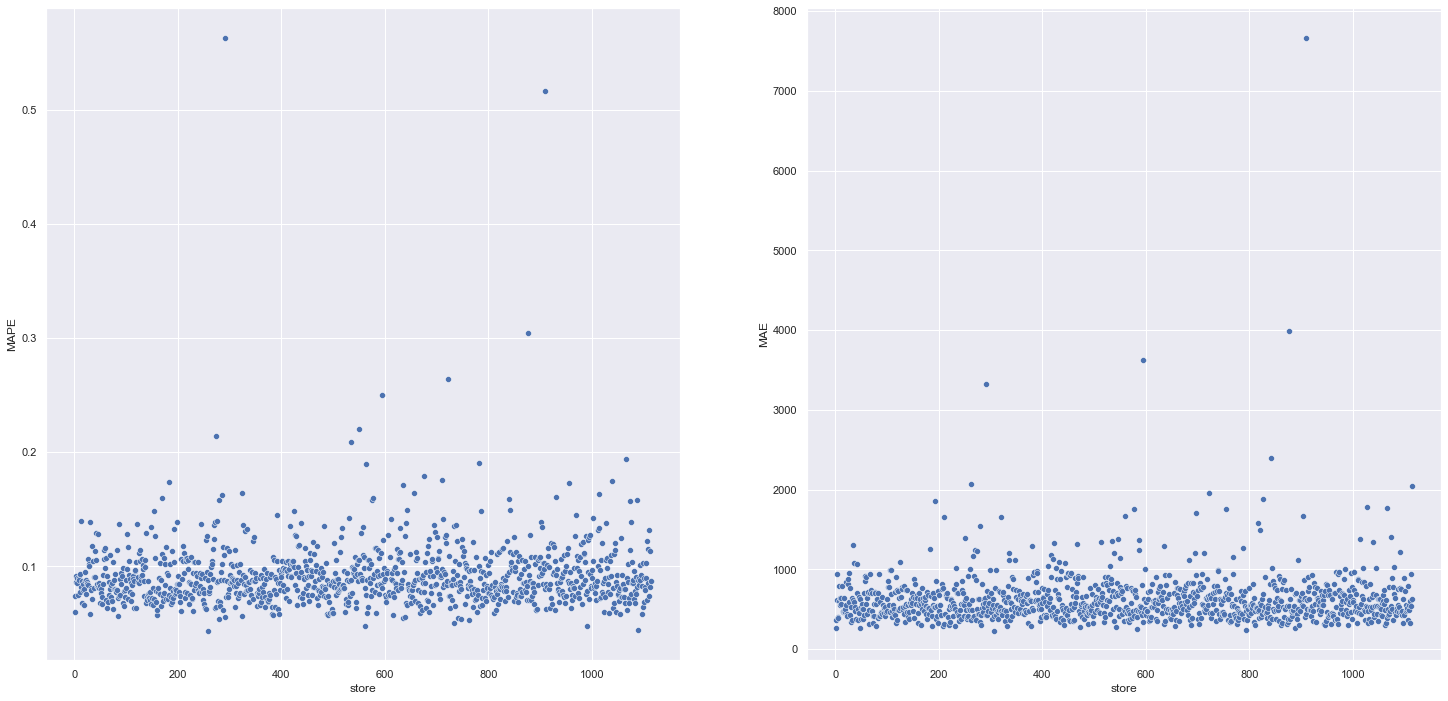

In [240]:
sales_predictions_next_six_weeks = pd.DataFrame({'store':X_test['store'], 'sales':y_test, 'sales_prediction':y_pred})
total_sales_predictions_per_store = sales_predictions_next_six_weeks.groupby('store').sum()
mae = sales_predictions_next_six_weeks.groupby('store').apply(lambda x: mean_absolute_error( x['sales'], x['sales_prediction'])).reset_index().rename(columns={0:'MAE'})
mape = sales_predictions_next_six_weeks.groupby('store').apply(lambda x: mean_absolute_percentage_error( x['sales'], x['sales_prediction'])).reset_index().rename(columns={0:'MAPE'})

# Merge
aux1 = pd.merge(mae, mape, how='inner', on='store')
aux2 = pd.merge(aux1, total_sales_predictions_per_store, how='inner', on='store')

plt.subplot(1,2,1)
sns.scatterplot(x='store', y='MAPE', data=aux2)

plt.subplot(1,2,2)
sns.scatterplot(x='store', y='MAE', data=aux2)

### Total Performance

In [266]:
total_sales_prediction = sales_predictions_next_six_weeks['sales_prediction'].sum()
best_scenario = total_sales_prediction + xgb_result_tuned['MAE'].values[0]
worst_scenario = total_sales_prediction - xgb_result_tuned['MAE'].values[0]

scenarios = pd.DataFrame({'Scenario':['Total Sales Prediction', 'Worst Scenario', 'Best Scenario'],
                'Value':[total_sales_prediction, worst_scenario, best_scenario]})

scenarios['Value'] = scenarios['Value'].map('R${:,.2f}'.format)
scenarios

,Scenario,Value
0,Total Sales Prediction,"R$284,728,480.00"
1,Worst Scenario,"R$284,727,850.32"
2,Best Scenario,"R$284,729,109.68"


### Machine Learning Performance

In [238]:
df_results = pd.DataFrame({'date':X_test['date'], 'store':X_test['store'], 'sales':y_test, 'sales_prediction':y_pred})
df_results['residual'] = df_results['sales'] - df_results['sales_prediction']
df_results['error_rate'] = df_results['sales_prediction']/df_results['sales']
df_results.head()

,date,store,sales,sales_prediction,residual,error_rate
0,2015-07-31,1,5263,5570.271484,-307.271484,1.058383
1,2015-07-31,2,6064,5938.439941,125.560059,0.979294
2,2015-07-31,3,8314,9731.746094,-1417.746094,1.170525
3,2015-07-31,4,13995,11682.929688,2312.070312,0.834793
4,2015-07-31,5,4822,6507.359863,-1685.359863,1.349515


<AxesSubplot:xlabel='sales_prediction', ylabel='residual'>

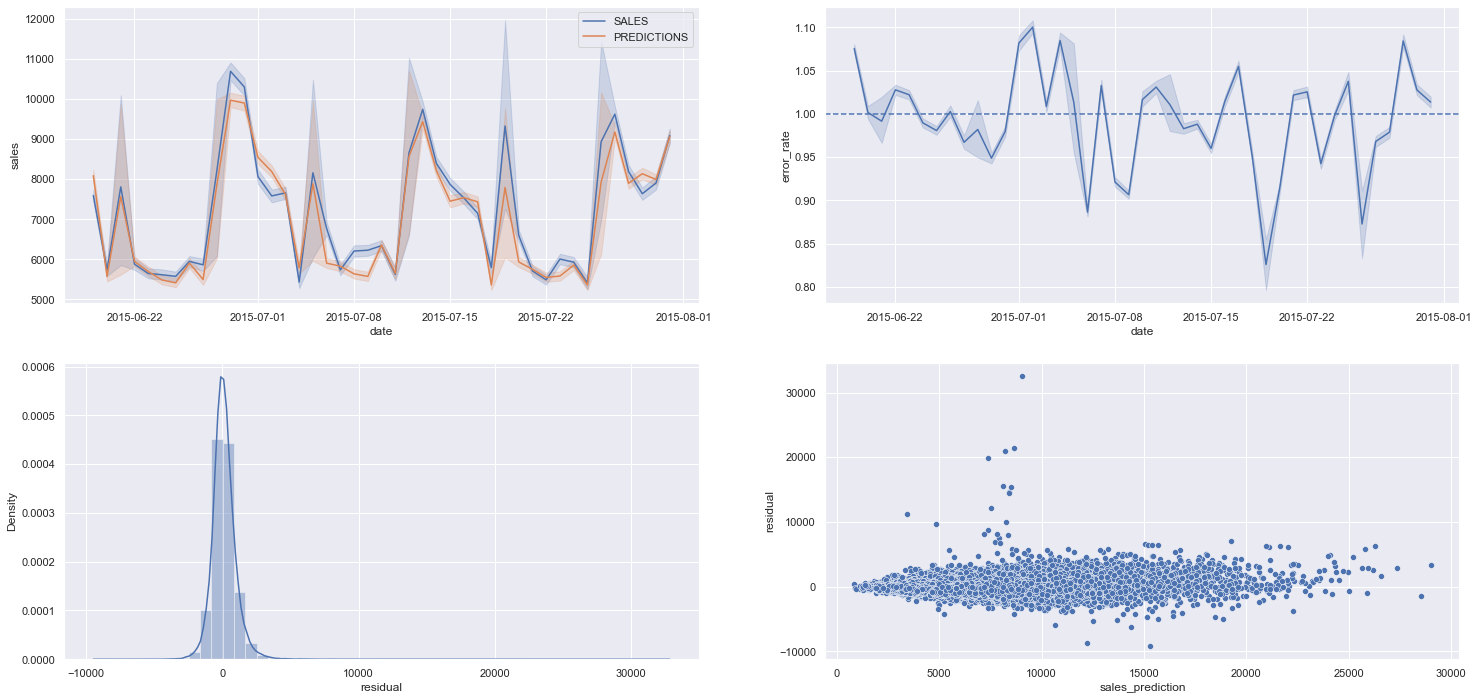

In [239]:
plt.subplot(2, 2, 1)
sns.lineplot( x='date', y='sales', data=df_results, label='SALES')
sns.lineplot( x='date', y='sales_prediction', data=df_results, label='PREDICTIONS')

plt.subplot(2, 2, 2)
sns.lineplot(x='date', y='error_rate', data=df_results)
plt.axhline(1, linestyle='--')

plt.subplot(2, 2, 3)
sns.distplot(df_results['residual'])

plt.subplot(2, 2, 4)
sns.scatterplot(df_results['sales_prediction'], df_results['residual'])

# Kaggle Submission